In [186]:
from visual_behavior import database as db
from visual_behavior.visualization.qc import data_loading as dl
from visual_behavior.translator.core.annotate import annotate_epochs

from visual_behavior.change_detection.trials import summarize

from multiprocessing import Pool

import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
%widescreen
%standard_imports

imported:
	os
	pandas as pd
	numpy as np
	matplotlib.pyplot as plt


In [3]:
pd.set_option('display.max_rows', 500)

In [185]:
epoch_summaries = pd.read_csv('/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/behavioral_state_characterization/motivation_states_by_epoch.2020.04.09.csv')

In [196]:
epoch_summaries.sample(5)

,mouse_id,behavior_session_uuid,startdatetime,epoch,num_contingent_trials,response_bias,discrim_p,flashwise_lick_probability,earned_water,lick_latency_median,fraction_time_aborted,number_of_go_trials,number_of_catch_trials,hit_rate,false_alarm_rate,d_prime,reward_lick_count,reward_lick_latency,"mean(HR,FA)",criterion,criterion_negative,motivation_state
11547,453911,99ecf31b-4caa-49a0-a118-493b453ecf28,2019-07-15 16:17:21.104,0.0,45.0,0.755556,0.063538,0.103448,0.231,0.450376,0.292831,41.0,4.0,0.804878,0.250000,1.533665,20.060606,0.146616,0.527439,-0.092343,0.092343,motivated
12897,453990,bc5011bc-dd43-4fde-a421-e1f791edd2df,2019-05-13 16:59:08.597,40.0,22.0,0.863636,0.048278,0.237589,0.180,0.400333,0.697598,19.0,3.0,0.947368,0.333333,2.050584,13.444444,0.169588,0.640351,-0.594564,0.594564,motivated
7898,436662,14a4cfc0-efaf-44ca-94e8-a6203a56d30b,2019-03-07 21:59:08.985,10.0,38.0,0.789474,0.000049,0.154122,0.210,0.483719,0.436743,33.0,5.0,0.909091,0.010000,3.661526,10.633333,0.144552,0.459545,0.495585,-0.495585,motivated
2499,403491,97f212db-d589-4d9a-8c4a-9d499175ceda,2018-10-18 19:56:54.172,60.0,0.0,NaN,1.000000,0.500000,0.000,NaN,1.000000,0.0,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,uncategorized
10398,449653,06cd3390-ffd9-4b26-97e1-9c2b4669ab27,2019-05-22 16:12:30.484,30.0,54.0,0.240741,0.860700,0.049853,0.084,0.433696,0.196014,47.0,7.0,0.255319,0.142857,0.409726,8.916667,0.155690,0.199088,0.862707,-0.862707,motivated


In [4]:
summary = db.get_behavior_session_summary()
id_map = pd.DataFrame([
    {
        'mouse_id':mouse_id, 
        'specimen_id':db.get_specimen_id_from_labtracks_id(mouse_id, show_warnings=False)
    } for mouse_id in summary['mouse_id'].unique()
])
summary = summary.merge(id_map, left_on='mouse_id', right_on='mouse_id', how='left')

In [5]:
cache = dl.get_qc_cache()
experiments = cache.get_experiment_table()

In [6]:
production_behavior_sessions = (
    summary[summary['specimen_id']
            .isin(experiments['specimen_id'].unique())]
            .drop(columns=['_id']).sort_values(by=['mouse_id', 'startdatetime'])
            .reset_index(drop=True)
)

In [7]:
def get_trials(uuid):
    try:
        vb = db.Database('visual_behavior_data')
        session_trials = pd.DataFrame(list(vb['behavior_data']['trials'].find({'behavior_session_uuid':uuid})))
        vb.close()
        return session_trials
    except KeyError:
        return None

In [18]:
def get_first_lick_latency(row):
    if len(row['lick_times']) > 0 and pd.notnull(row['change_time']):
        return row['lick_times'][0] - row['change_time']
    else:
        return None

In [8]:
%%time
with Pool(32) as pool:
    all_trials = pool.map(get_trials, production_behavior_sessions['behavior_session_uuid'].values)
all_trials = pd.concat(all_trials)

CPU times: user 47.2 s, sys: 4.53 s, total: 51.7 s
Wall time: 1min 11s


In [21]:
%%time
all_trials['first_lick_latency'] = all_trials[['lick_times','change_time']].apply(get_first_lick_latency, axis=1)

CPU times: user 1min 7s, sys: 675 ms, total: 1min 8s
Wall time: 1min 8s


In [142]:
all_trials['last_response_type'] = all_trials['response_type'].shift(1)
all_trials['next_response_type'] = all_trials['response_type'].shift(-1)

In [190]:
all_trials = annotate_epochs(all_trials.reset_index(), epoch_length=10)

In [198]:
all_trials = all_trials.merge(
    epoch_summaries[['behavior_session_uuid','epoch','criterion_negative','motivation_state']],
    left_on = ['behavior_session_uuid','epoch'],
    right_on = ['behavior_session_uuid','epoch'],
    how='left'
)

In [199]:
go_trials = all_trials.query('trial_type == "go"')

In [200]:
go_trials.sample(20)[['behavior_session_uuid','trial_type','response_type','last_response_type','first_lick_latency','epoch','motivation_state']]

,behavior_session_uuid,trial_type,response_type,last_response_type,first_lick_latency,epoch,motivation_state
3072798,eceeb725-7e15-47c2-a3ec-9920d30dab29,go,MISS,MISS,NaN,50.0,under_motivated
3015764,1105bedd-d17e-4ad2-b0f5-2bc70d355b47,go,MISS,MISS,NaN,30.0,under_motivated
1325516,585ec0a2-8004-44c3-89ea-2f1878345da0,go,MISS,MISS,1.417849,10.0,motivated
2965272,420e5da5-a410-4326-b4d2-708aa01816a8,go,MISS,EARLY_RESPONSE,NaN,30.0,motivated
3469316,8e3d9264-3b91-4937-8319-e1e5932f03fb,go,MISS,EARLY_RESPONSE,NaN,0.0,motivated
458167,cb5fbafa-6677-4b88-a75c-1e97ed1a7937,go,MISS,MISS,0.750590,0.0,motivated
2677125,ab9a0095-f821-4bd6-95ec-112728138f60,go,MISS,CR,NaN,10.0,under_motivated
3543521,9220885a-fd65-4f34-95a5-16f6a27e95b3,go,MISS,CR,NaN,20.0,under_motivated
2596860,54fff246-0518-4d0a-8955-b57f8f54a6b7,go,MISS,MISS,0.967487,30.0,motivated
2081338,7a9d8dcb-2f81-4977-af1d-1ebd4a843f75,go,MISS,MISS,NaN,30.0,under_motivated


In [201]:
go_trials_with_response = go_trials[pd.notnull(go_trials['first_lick_latency'])]
go_trials_with_response[['trial_type','response_type','last_response_type','next_response_type','first_lick_latency']]

,trial_type,response_type,last_response_type,next_response_type,first_lick_latency
13,go,HIT,EARLY_RESPONSE,EARLY_RESPONSE,0.266897
15,go,HIT,EARLY_RESPONSE,EARLY_RESPONSE,0.283576
17,go,HIT,EARLY_RESPONSE,EARLY_RESPONSE,0.250240
20,go,HIT,EARLY_RESPONSE,EARLY_RESPONSE,0.333581
27,go,HIT,EARLY_RESPONSE,EARLY_RESPONSE,0.250230
...,...,...,...,...,...
3573567,go,MISS,EARLY_RESPONSE,MISS,0.050027
3573569,go,MISS,MISS,MISS,0.834001
3573632,go,MISS,MISS,EARLY_RESPONSE,2.018344
3573638,go,HIT,MISS,EARLY_RESPONSE,0.567163


In [202]:
response_summary = {}
response_summary['last'] = pd.DataFrame({'last_response_type':go_trials_with_response['last_response_type'].unique()}).set_index('last_response_type')
response_summary['next'] = pd.DataFrame({'next_response_type':go_trials_with_response['next_response_type'].unique()}).set_index('next_response_type')
response_summary['last']

""
last_response_type
EARLY_RESPONSE
HIT
MISS
CR
FA


In [203]:
for response_type in ['last','next']:
    label = '{}_response_type'.format(response_type)
    response_summary[response_type] = pd.DataFrame({label:go_trials_with_response[label].unique()}).set_index(label)
    for agg_func in ['mean','median','std','count']:
        query = 'first_lick_latency > 0 and first_lick_latency < 3 and motivation_state == "motivated"'
        response_summary[response_type] = pd.merge(
            response_summary[response_type],
            pd.DataFrame(go_trials_with_response.query(query).groupby(label)['first_lick_latency'].agg(agg_func)).rename(columns={'first_lick_latency':str(agg_func)}),
            left_index=True,
            right_index=True,
        )
    response_summary[response_type] = response_summary[response_type].sort_values(by=label)
response_summary['last']

,mean,median,std,count
last_response_type,,,,
CR,0.626742,0.517102,0.416236,18868
EARLY_RESPONSE,0.591216,0.483685,0.435899,234671
FA,0.623938,0.500468,0.447549,3743
HIT,0.552438,0.450336,0.408451,72918
MISS,0.726638,0.583827,0.504448,46356


In [204]:
response_summary['next']

,mean,median,std,count
next_response_type,,,,
CR,0.688786,0.517113,0.525658,14440
EARLY_RESPONSE,0.562509,0.467056,0.392325,245843
FA,0.609766,0.500363,0.440692,4196
HIT,0.613325,0.483729,0.457716,76095
MISS,0.817197,0.617191,0.595354,35982


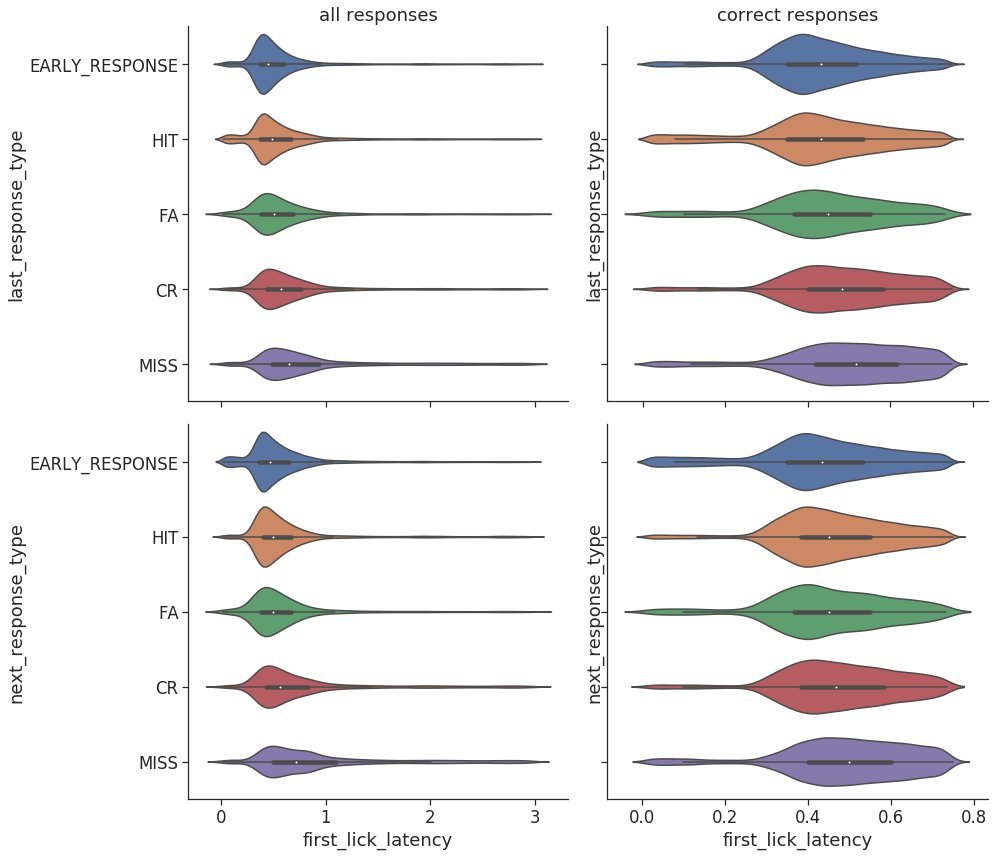

In [205]:
fig, ax = plt.subplots(2,2,figsize=(14,12), sharey=True)
titles = ['all responses','correct responses']
for row,response_type in enumerate(['last','next']):
    for col,max_latency in enumerate([3,0.75]):
        sns.violinplot(
            y="{}_response_type".format(response_type), 
            x="first_lick_latency", 
            data=go_trials_with_response.query('first_lick_latency > 0 and first_lick_latency < @max_latency'),
            order=response_summary[response_type].sort_values(by='median').index.values,
            ax = ax[row,col],
        )
        if row == 0:
            ax[row,col].set_xticklabels([])
            ax[row,col].set_xlabel('')
            ax[row,col].set_title(titles[col])
fig.tight_layout()

In [207]:
groups = [go_trials_with_response.query('first_lick_latency > 0 and first_lick_latency < 3 and last_response_type == @lrt')['first_lick_latency'] for lrt in summary_df.index]

In [208]:
summary_df.index

Index(['HIT', 'EARLY_RESPONSE', 'FA', 'CR', 'MISS'], dtype='object', name='last_response_type')

In [209]:
stats.f_oneway(*groups)

F_onewayResult(statistic=4395.4442365606765, pvalue=0.0)

In [210]:
stats.ttest_ind(
    groups[1],
    groups[2]
)

Ttest_indResult(statistic=-1.5379735239340109, pvalue=0.12405613460339418)

(array([0.34752468, 0.46537563, 0.45625801, 0.38587898, 0.32936478,
        0.56597091, 1.52369829, 2.62941753, 2.78878758, 2.22861879,
        1.83980107, 1.49363273, 1.19501168, 0.97905207, 0.80679677,
        0.67598523, 0.55195539, 0.43139176, 0.30547811]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <a list of 19 Patch objects>)

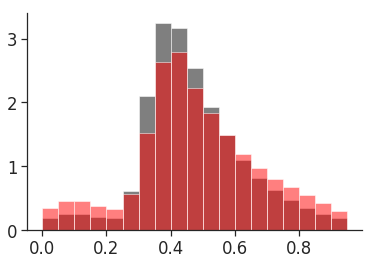

In [211]:
fig,ax=plt.subplots()
ax.hist(groups[0],bins=np.arange(0,1,0.05),color='black',normed=True,alpha=0.5)
ax.hist(groups[1],bins=np.arange(0,1,0.05),color='red',normed=True,alpha=0.5)